## ASK joint: NicheNet preparations

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

# making sure plots & clusters are reproducible
np.random.seed(42)

# custom functions
import sc_toolbox as sct

Running Scanpy 1.8.2, on 2022-10-29 17:17.


In [2]:
## path variables
adata_dir = '/home/niklas/data/220107_Human_PCLS_ASK_joint/220107_PCLS_human_ASK_joint_annotated_NIKLAS.h5ad'
project_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/01_data/NicheNet_inputs/'

In [3]:
## plotting variables
sc.settings.figdir = '/home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/02_figures/ASK_joint/'
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['pdf.fonttype'] = 42

In [4]:
## load anndata object
adata = sc.read(adata_dir)

In [5]:
## have a look at the adata object
adata

AnnData object with n_obs × n_vars = 63581 × 17343
    obs: 'condition', 'modality', 'name', 'patient', 'timepoint', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'cell_type', 'cell_type_group'
    var: 'n_cells', 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'cell_type_group_colors', 'condition_colors', 'dendrogram_cell_type', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'modality_colors', 'name_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities', 'distances'

In [6]:
adata = adata[adata.obs.treatment.isin(['CC','FC'])].copy()

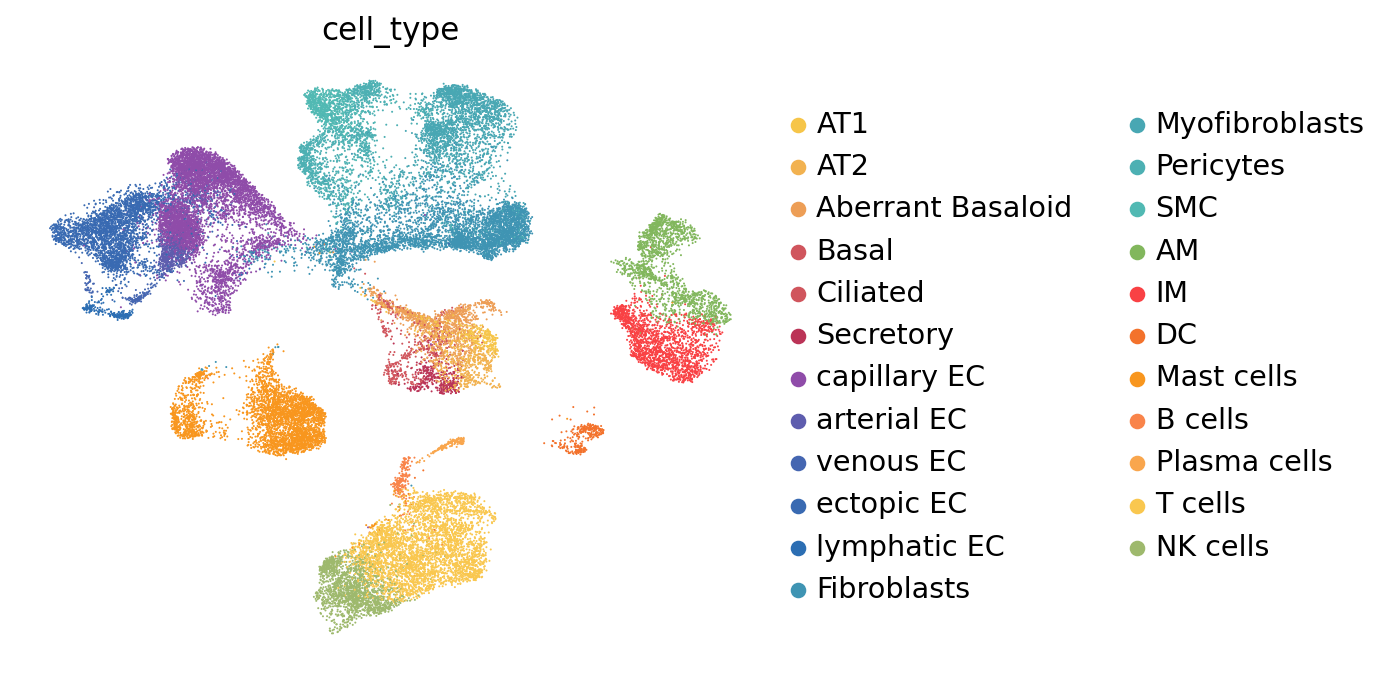

In [7]:
## overview UMAPs
sc.pl.umap(adata, color = ['cell_type'], ncols = 1, frameon = False)

In [8]:
adata.obs['cell_type'] = ['Macrophages' if ct in ['AM','IM'] else ct for ct in adata.obs['cell_type']]
adata.obs['cell_type'] = ['SMC/Pericytes' if ct in ['SMC','Pericytes'] else ct for ct in adata.obs['cell_type']]

In [9]:
adata.obs['cell_type_nichenet'] = adata.obs.loc[:, ['cell_type', 'treatment']].agg('_'.join, axis = 1)
sc._utils.sanitize_anndata(adata)

/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_nichenet' as categorical


In [10]:
adata.obs['cell_type_nichenet'] = ['Aberrant Basaloid' if ct.startswith('Aberrant Basaloid') else ct for ct in adata.obs['cell_type_nichenet']]
adata.obs['cell_type_nichenet'] = ['Myofibroblasts' if ct.startswith('Myofibroblasts') else ct for ct in adata.obs['cell_type_nichenet']]
adata.obs['cell_type_nichenet'] = ['ectopic EC' if ct.startswith('ectopic EC') else ct for ct in adata.obs['cell_type_nichenet']]

In [11]:
adata.obs['cell_type_nichenet'].value_counts()

capillary EC_CC      5476
Fibroblasts_CC       3625
ectopic EC           3194
T cells_FC           2898
Myofibroblasts       2670
Mast cells_FC        2660
Macrophages_FC       1894
Macrophages_CC       1540
SMC/Pericytes_FC     1482
NK cells_FC          1204
Aberrant Basaloid    1120
T cells_CC            988
SMC/Pericytes_CC      975
Fibroblasts_FC        969
Mast cells_CC         875
capillary EC_FC       658
arterial EC_CC        582
NK cells_CC           548
AT2_CC                431
AT1_CC                276
DC_FC                 218
Secretory_FC          196
Basal_CC              176
Secretory_CC          174
Ciliated_FC           159
lymphatic EC_FC       154
lymphatic EC_CC       154
venous EC_CC          146
B cells_FC            114
AT1_FC                 90
B cells_CC             89
Plasma cells_FC        85
DC_CC                  72
Plasma cells_CC        54
Ciliated_CC            53
Basal_FC               50
venous EC_FC           42
AT2_FC                 16
arterial EC_

In [12]:
## function to add pct expressed 
def add_pct(adata, tab, ids, group_by, thresh_min=0, gene_label='gene'):
    for ident in ids:
        
        # subset to cell type of interest
        cells_oi = adata.obs_names[adata.obs[group_by] == ident]
        # compute fraction (%) of cell type expressing each marker genes
        data_temp_oi = pd.DataFrame(((adata[cells_oi].layers['counts'] > 0).sum(0)
                / adata[cells_oi].layers['counts'].shape[0]).T, index=adata.var_names)
        
        # subset to all other cells (background)
        cells_background = adata.obs_names[adata.obs[group_by] != ident]
        # compute fraction (%) to background expressing each marker genes
        data_temp_background = pd.DataFrame(((adata[cells_background].layers['counts'] > 0).sum(0)
                / adata[cells_background].layers['counts'].shape[0]).T, index=adata.var_names)
        
        if gene_label == 'index':
            tab[f'pct_cell_type'] = data_temp_oi.reindex(tab.index.values).values
            tab[f'pct_background'] = data_temp_background.reindex(tab.index.values).values
        else:
            tab[f'pct_cell_type'] = data_temp_oi.reindex(tab.loc[:, gene_label]).values
            tab[f'pct_background'] = data_temp_background.reindex(tab.loc[:, gene_label]).values
    return tab

In [13]:
label = 'cell_type_nichenet'

In [14]:
## calculate marker genes
sc.tl.rank_genes_groups(adata, groupby = label, groups = 'all', use_raw = True, method = 'wilcoxon', n_genes=500)

ranking genes


/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_nichenet' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:34)


/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/scanpy/to

In [15]:
## create marker table
result = adata.uns['rank_genes_groups']
all_markers = []
for cell_type in result['names'].dtype.names:
    ct_table = pd.DataFrame({'gene': result['names'][cell_type], 'score': result['scores'][cell_type],
                            'logfoldchange': result['logfoldchanges'][cell_type], 'pval': result['pvals'][cell_type],
                            'pval_adj': result['pvals_adj'][cell_type], 'cell_type': cell_type})
    # compute pct expressed for cell type and background
    ct_table = add_pct(adata, ct_table, [cell_type], group_by = label)
    # append to all markers table
    all_markers.append(ct_table)
    
## concat into pandas df  
all_markers = pd.concat(all_markers)

## filter by p value
all_markers = all_markers[all_markers.pval_adj < 0.1].copy()
## only consider genes expressed in at least 25% of cells of cell type of interest
all_markers = all_markers[all_markers.pct_cell_type > 0.25].copy()
## sort marker gene table by log FC and adjusted FC
all_markers = all_markers.sort_values(['cell_type','logfoldchange','pval_adj'], ascending=[True,False,True])
all_markers.head()

,gene,score,logfoldchange,pval,pval_adj,cell_type,pct_cell_type,pct_background
304,GKN2,10.689283,7.264412,1.142505e-26,6.596964e-25,AT1_CC,0.376812,0.004631
143,SFTPC,13.793005,7.262094,2.808150e-43,3.476143e-41,AT1_CC,0.489130,0.008844
2,KRT7,26.171324,7.205437,5.636866e-151,3.395836e-147,AT1_CC,0.938406,0.054934
41,SCEL,19.195934,6.629783,4.002270e-82,1.722215e-79,AT1_CC,0.681159,0.017102
3,KRT18,25.870832,6.605252,1.418566e-147,6.409434e-144,AT1_CC,0.927536,0.073208


In [16]:
## save marker table
all_markers.to_csv(project_dir + '221029_PCLS_human_ASK_joint_celltype_marker_table_OVERALL_cell_circuits.csv', index = False)

### Calculate average expression table

In [17]:
## for each treatment separately - but always pooled with CC
for treatment in ['FC']:
    adata_sub = adata[adata.obs.treatment.isin(['CC',treatment])].copy()
    avg_expr_ct = pd.DataFrame(columns=adata_sub.var_names, index=adata_sub.obs['cell_type_nichenet'].cat.categories)                                                                                                 
    for cell_type in adata_sub.obs.cell_type_nichenet.cat.categories: 
        avg_expr_ct.loc[cell_type] = adata_sub[adata_sub.obs['cell_type_nichenet'].isin([cell_type]),:].X.mean(0)
    avg_expr_ct = avg_expr_ct.transpose()
    avg_expr_ct_SCALED = avg_expr_ct.apply(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)), axis = 1)
    avg_expr_ct.to_csv(project_dir + '221029_ASK_joint_Human_PCLS_CC_' + treatment + '_avg_expr_cell_type_level.csv')
    avg_expr_ct_SCALED.to_csv(project_dir + '221029_ASK_joint_Human_PCLS_CC_' + treatment + '_avg_expr_SCALED_cell_type_level.csv')

### Calculate pct expression tables

In [18]:
## for each treatment separately - but always pooled with CC
for treatment in ['FC']:
    adata_sub = adata[adata.obs.treatment.isin(['CC',treatment])].copy()
    pct_expr_ct = pd.DataFrame(columns=adata_sub.raw.var_names, index=adata_sub.obs['cell_type_nichenet'].cat.categories) 
    for cell_type in adata_sub.obs.cell_type_nichenet.cat.categories:
        cells = adata_sub.obs_names[adata_sub.obs['cell_type_nichenet'] == cell_type]
        pct_expr_ct.loc[cell_type] = (adata_sub.raw[cells].X > 0).sum(0) / adata_sub.raw[cells].X.shape[0]
    pct_expr_ct = pct_expr_ct.transpose()
    pct_expr_ct.to_csv(project_dir + '22221029_ASK_joint_Human_PCLS_CC_' + treatment + '_pct_expr_cell_type_level.csv')